In [1]:
import os
import tensorflow as tf

# Shut TensorFlow up
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"   # 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR
tf.get_logger().setLevel('ERROR')

2025-10-05 07:54:23.242804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759650863.412372      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759650863.460573      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import copy
import cv2

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import RandomFlip, RandomRotation

from keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
def seed_everything(seed):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(50)

In [4]:
tf. __version__

'2.18.0'

In [5]:
dataset_dir = r"//kaggle//input//dataset//Dataset//Crop___Disease//"
train_dir = r"//kaggle//input/dataset//Dataset//Train//"
test_dir = r"//kaggle//input/dataset//Dataset//Test//"
validation_dir = r"//kaggle//input/dataset//Dataset//Validation//"

## EDA

In [6]:
train_data = []

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        train_data.append((file_path, class_name))

In [7]:
train_df = pd.DataFrame(train_data, columns=['File_Path', 'Class_Name'])
train_df

File_Path Class_Name
0     //kaggle//input/dataset//Dataset//Train//7/IMG...          7
1     //kaggle//input/dataset//Dataset//Train//7/IMG...          7
2     //kaggle//input/dataset//Dataset//Train//7/IMG...          7
3     //kaggle//input/dataset//Dataset//Train//7/IMG...          7
4     //kaggle//input/dataset//Dataset//Train//7/IMG...          7
...                                                 ...        ...
9107  //kaggle//input/dataset//Dataset//Train//11/Br...         11
9108  //kaggle//input/dataset//Dataset//Train//11/Br...         11
9109  //kaggle//input/dataset//Dataset//Train//11/Br...         11
9110  //kaggle//input/dataset//Dataset//Train//11/Br...         11
9111  //kaggle//input/dataset//Dataset//Train//11/Br...         11

[9112 rows x 2 columns]

In [8]:
train_df['Class_Name'].value_counts().sort_index()

Class_Name
0      834
1      359
10     700
11     631
12     781
13     646
2      813
3      689
4      700
5      106
6      700
7      429
8     1041
9      683
Name: count, dtype: int64

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
])

I0000 00:00:1759650877.833164      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759650877.833902      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [10]:
train_df['File_Path'][0]

'//kaggle//input/dataset//Dataset//Train//7/IMG_20190419_103257.jpg'

In [11]:
category = ['Corn Common Rust','Corn Gray Leaf','Corn Healthy','Corn Northern Leaf Blight','Potato Early Blight','Potato Healthy','Potato Late Blight','Rice Brown Spot','Rice Healthy','Rice Leaf Blast','Rice Neck Blast','Wheat Brown Rust','Wheat Healthy','Wheat Yellow Rust']
count = [1192, 513, 1162, 985,1000, 152, 1000, 613, 1488, 977, 1000, 902, 1116, 924]

In [12]:
crop_df = pd.DataFrame({'Category': ['Corn Common Rust','Corn Gray Leaf','Corn Healthy','Corn Northern Leaf Blight','Potato Early Blight','Potato Healthy','Potato Late Blight','Rice Brown Spot','Rice Healthy','Rice Leaf Blast','Rice Neck Blast','Wheat Brown Rust','Wheat Healthy','Wheat Yellow Rust'],
                   'total_image': [1192, 513, 1162, 985,1000, 152, 1000, 613, 1488, 977, 1000, 902, 1116, 924]})
crop_df.set_index('Category', inplace=True)
crop_df

total_image
Category                              
Corn Common Rust                  1192
Corn Gray Leaf                     513
Corn Healthy                      1162
Corn Northern Leaf Blight          985
Potato Early Blight               1000
Potato Healthy                     152
Potato Late Blight                1000
Rice Brown Spot                    613
Rice Healthy                      1488
Rice Leaf Blast                    977
Rice Neck Blast                   1000
Wheat Brown Rust                   902
Wheat Healthy                     1116
Wheat Yellow Rust                  924

<Axes: title={'center': 'Image Distribution for Class Labels'}, ylabel='total_image'>

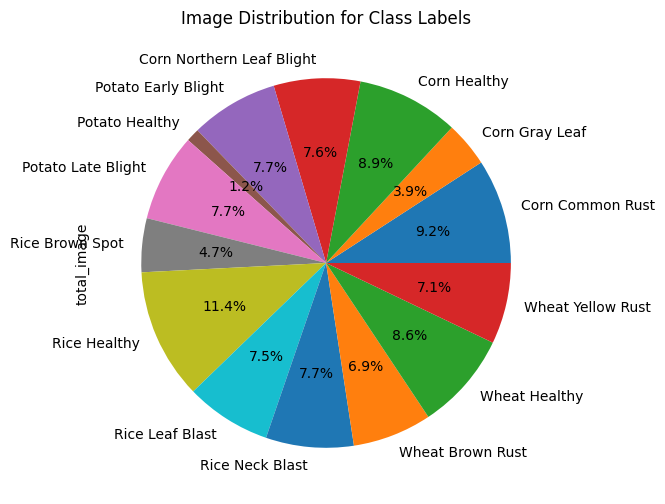

In [13]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(111)
crop_df.total_image.plot(kind='pie', ax=ax, startangle=0, fontsize=10, autopct='%1.1f%%', title='Image Distribution for Class Labels')

In [14]:
plant_df = pd.DataFrame({'Plants': ['Corn','Potato','Rice','Wheat'],
                   'total_image': [3852, 2152, 4078, 2942]})
plant_df.set_index('Plants', inplace=True)
plant_df

total_image
Plants             
Corn           3852
Potato         2152
Rice           4078
Wheat          2942

In [15]:
img_width, img_height = 299, 299

In [16]:
EDA_class_names = ['Corn Common Rust', 'Corn Gray Leaf Spot', 'Corn Healthy', 'Corn Northern Leaf Blight']

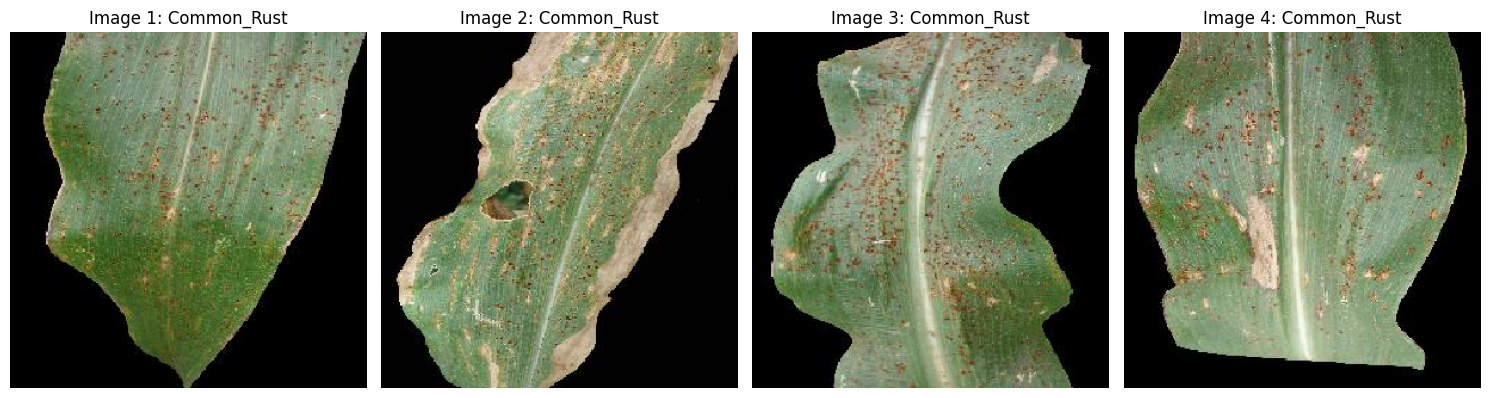

In [17]:
desired_class = "0"
name = "Common_Rust"

desired_class_df = train_df[train_df['Class_Name'] == desired_class]

num_images_to_plot = 4

fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))

for i, (index, row) in enumerate(desired_class_df.head(num_images_to_plot).iterrows()):
    image_path = row['File_Path']
    image = load_img(image_path, target_size=(img_width, img_height))

    axes[i].imshow(image)
    axes[i].set_title(f"Image {i+1}: {name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

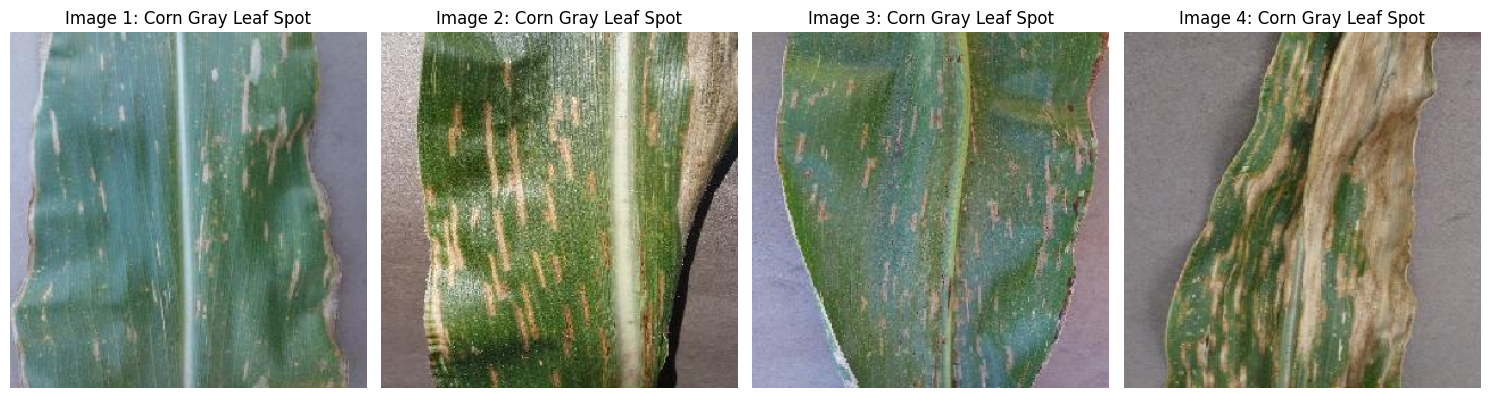

In [18]:
desired_class = "1"
name = "Corn Gray Leaf Spot"

desired_class_df = train_df[train_df['Class_Name'] == desired_class]

num_images_to_plot = 4

fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))

for i, (index, row) in enumerate(desired_class_df.head(num_images_to_plot).iterrows()):
    image_path = row['File_Path']
    image = load_img(image_path, target_size=(img_width, img_height))

    axes[i].imshow(image)
    axes[i].set_title(f"Image {i+1}: {name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

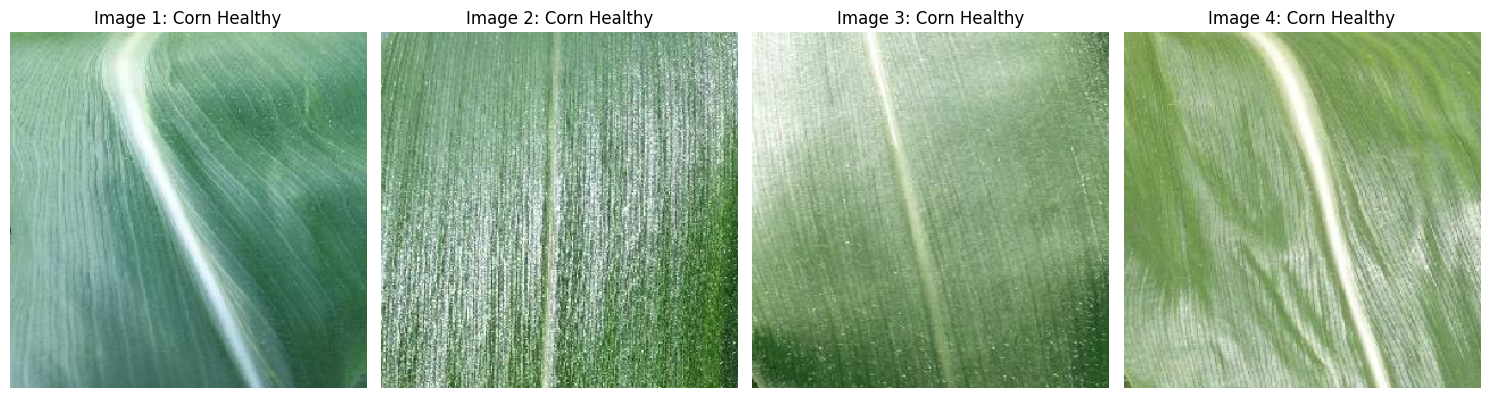

In [19]:
desired_class = "2"
name = "Corn Healthy"

desired_class_df = train_df[train_df['Class_Name'] == desired_class]

num_images_to_plot = 4

fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))

for i, (index, row) in enumerate(desired_class_df.head(num_images_to_plot).iterrows()):
    image_path = row['File_Path']
    image = load_img(image_path, target_size=(img_width, img_height))

    axes[i].imshow(image)
    axes[i].set_title(f"Image {i+1}: {name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

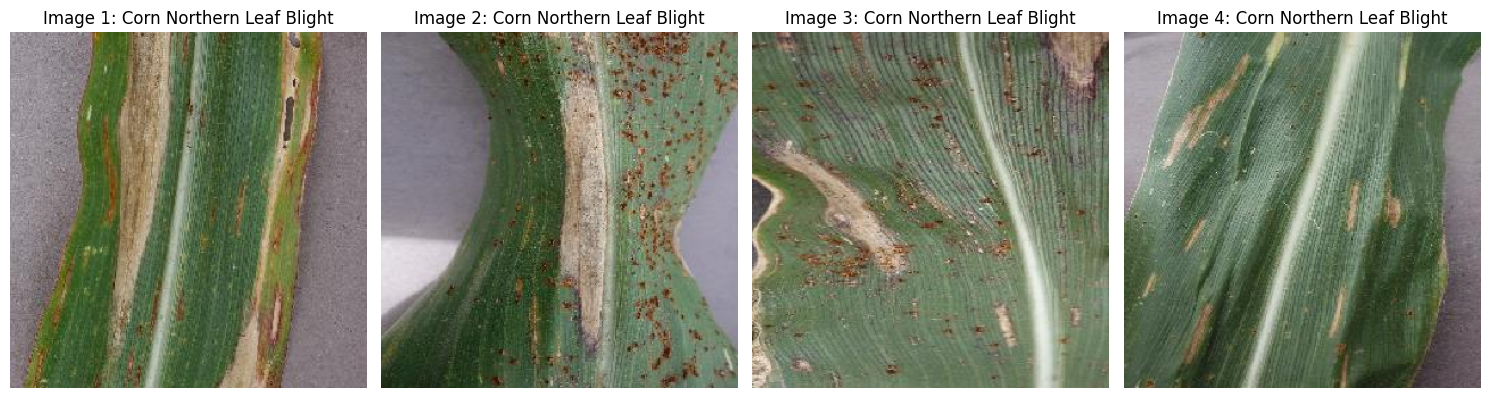

In [20]:
desired_class = "3"
name = "Corn Northern Leaf Blight"

desired_class_df = train_df[train_df['Class_Name'] == desired_class]

num_images_to_plot = 4

fig, axes = plt.subplots(1, num_images_to_plot, figsize=(15, 5))

for i, (index, row) in enumerate(desired_class_df.head(num_images_to_plot).iterrows()):
    image_path = row['File_Path']
    image = load_img(image_path, target_size=(img_width, img_height))

    axes[i].imshow(image)
    axes[i].set_title(f"Image {i+1}: {name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## VGG 19

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

batch_size = 8

In [22]:
from tensorflow.keras.applications.vgg19 import VGG19

In [23]:

#model3 = VGG19(include_top=False,input_shape=(228, 228, 3), weights='imagenet')

from tensorflow.keras.applications import VGG19

model3 = VGG19(include_top=False, input_shape=(228, 228, 3), weights=None)

In [24]:
input_shape= (228, 228)

In [25]:
datagen_train2 = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test2 = ImageDataGenerator(rescale=1./255)
datagen_val2 = ImageDataGenerator(rescale=1./255)


generator_train2 = datagen_train2.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test2 = datagen_test2.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

generator_val2 = datagen_val2.flow_from_directory(directory=validation_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)


Found 9112 images belonging to 14 classes.
Found 2600 images belonging to 14 classes.
Found 1312 images belonging to 14 classes.


In [26]:
math.ceil(generator_train2.samples)

9112

In [27]:
next(generator_train2)[1]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [28]:
conv_model2 = Model(inputs=model3.input, outputs=model3.output)
new_model2 = Sequential()
new_model2.add(conv_model2)
new_model2.add(Flatten())
new_model2.add(Dropout(0.5))
new_model2.add(Dense(512, activation='relu'))
new_model2.add(Dense(14, activation='softmax'))

In [29]:
new_model2.compile(optimizer= opt, loss=loss, metrics=metrics)

In [30]:
num_iters = 30000
num_batches_train = generator_train2.n // batch_size

epochs = int(num_iters / num_batches_train)
print("Epoch: ",epochs)
desired_train_accuracy = 0.99

steps_per_epoch = generator_train2.n // batch_size
steps_val = generator_val2.n // batch_size
print("Steps_per_epoch: ",steps_per_epoch)
print("Steps_val: ",steps_val)

Epoch:  26
Steps_per_epoch:  1139
Steps_val:  164


In [31]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

# Custom callback to stop when desired training accuracy is reached
class DesiredAccuracyCallback(Callback):
    def __init__(self, desired_accuracy):
        super(DesiredAccuracyCallback, self).__init__()
        self.desired_accuracy = desired_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= self.desired_accuracy:
            print(f"Desired training accuracy of {self.desired_accuracy*100:.2f}% reached. Stopping training.")
            self.model.stop_training = True

# Save full model in new Keras format
Checkpoint = ModelCheckpoint("VGG19.keras", monitor="val_accuracy", save_best_only=True, mode="max")

# Save just weights in the proper new naming convention
WeightsOnly = ModelCheckpoint("VGG19.weights.h5", monitor="val_accuracy", save_best_only=True, 
                              mode="max", save_weights_only=True)

# Custom desired accuracy stopper
DesiredAccStop = DesiredAccuracyCallback(desired_train_accuracy)

# Early stopping on validation loss
EarlyStop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, mode="auto")

# Training loop
history2 = new_model2.fit(
    generator_train2,
    epochs=epochs,
    callbacks=[Checkpoint, WeightsOnly, DesiredAccStop, EarlyStop],
    steps_per_epoch=steps_per_epoch,
    validation_data=generator_val2,
    validation_steps=steps_val
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/26


I0000 00:00:1759650895.319369      60 service.cc:148] XLA service 0x7bc748062390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759650895.320283      60 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759650895.320308      60 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759650896.123397      60 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1759650909.788115      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1139/1139 ━━━━━━━━━━━━━━━━━━━━ 301s 245ms/step - accuracy: 0.2785 - loss: 1.9440 - val_accuracy: 0.3963 - val_loss: 1.2839
Epoch 2/26
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 276s 242ms/step - accuracy: 0.4388 - loss: 1.3109 - val_accuracy: 0.6250 - val_loss: 0.8766
Epoch 3/26
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 277s 243ms/step - accuracy: 0.6093 - loss: 0.9490 - val_accuracy: 0.7500 - val_loss: 0.6417
Epoch 4/26
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 277s 243ms/step - accuracy: 0.7163 - loss: 0.7098 - val_accuracy: 0.7912 - val_loss: 0.5374
Epoch 5/26
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 274s 240ms/step - accuracy: 0.7673 - loss: 0.6057 - val_accuracy: 0.7706 - val_loss: 0.5194
Epoch 6/26
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 276s 242ms/step - accuracy: 0.7862 - loss: 0.5471 - val_accuracy: 0.8011 - val_loss: 0.4496
Epoch 7/26
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 273s 240ms/step - accuracy: 0.8084 - loss: 0.4663 - val_accuracy: 0.7538 - val_loss: 0.5611
Epoch 8/26
1139/1139 ━━━━━━━━━━━━━━━━━━━━ 275s 242ms/step - accuracy: 0.8

In [32]:
new_model2 = tf.keras.models.load_model('/kaggle/working/VGG19.keras')

In [33]:
Y_pred2 = new_model2.predict(generator_test2)
y_pred2 = np.argmax(Y_pred2, axis=1)

325/325 ━━━━━━━━━━━━━━━━━━━━ 45s 136ms/step


In [34]:
class_labels = list(generator_test2.class_indices.keys())

In [35]:
print(classification_report(generator_test2.classes, y_pred2, target_names=class_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       238
           1       0.79      0.89      0.84       102
          10       0.98      0.98      0.98       200
          11       0.99      0.96      0.97       180
          12       0.98      1.00      0.99       223
          13       0.99      0.99      0.99       184
           2       1.00      1.00      1.00       232
           3       0.93      0.87      0.90       197
           4       0.97      0.99      0.98       200
           5       0.97      1.00      0.98        30
           6       0.98      0.98      0.98       200
           7       0.64      0.51      0.57       122
           8       0.78      0.94      0.85       297
           9       0.70      0.55      0.62       195

    accuracy                           0.91      2600
   macro avg       0.91      0.90      0.90      2600
weighted avg       0.91      0.91      0.91      2600



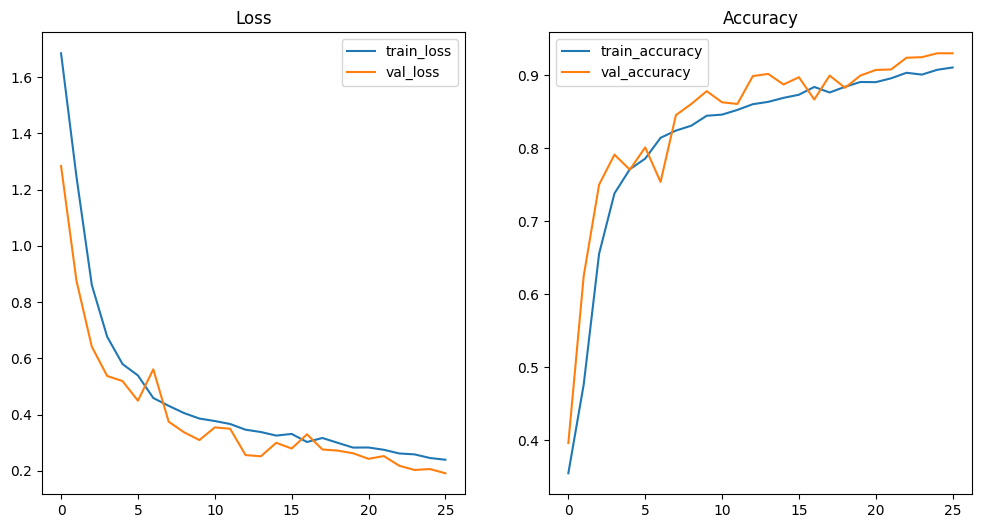

In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history2.history["loss"], label="train_loss")
plt.plot(history2.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history2.history["accuracy"], label="train_accuracy")
plt.plot(history2.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.title("Accuracy")

plt.show()

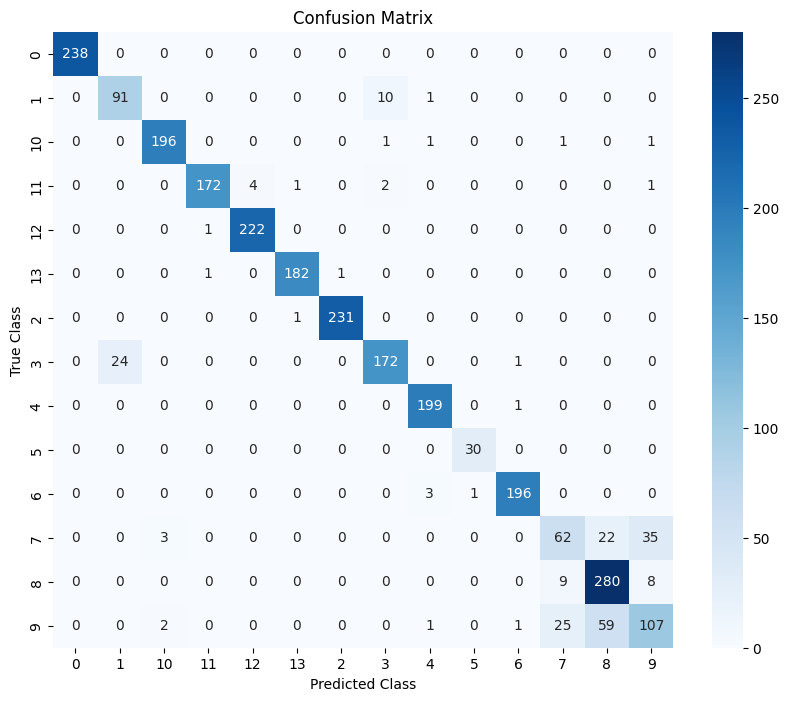

In [37]:
cm2 = confusion_matrix(generator_test2.classes, y_pred2)

plt.figure(figsize=(10, 8))
sns.heatmap(cm2, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

In [38]:
image_path_show_V=[]
image_show_V=[]

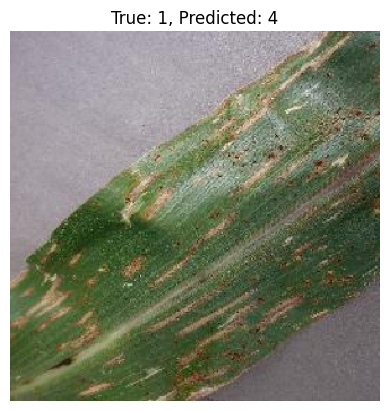

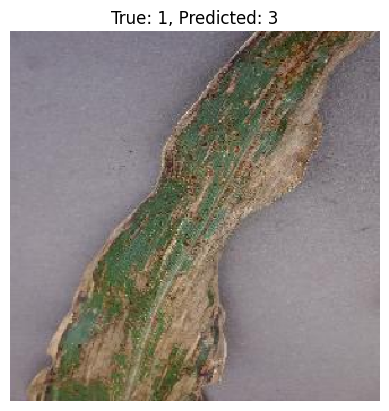

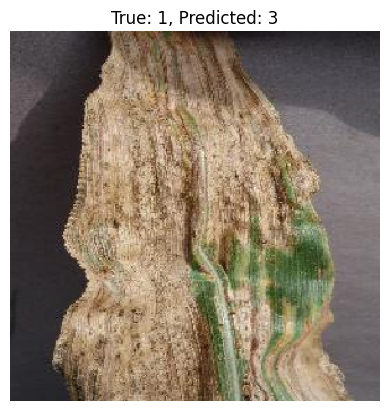

In [39]:
img_width, img_height= 299, 299
misclassified_images_V = []
for i in range(len(y_pred2)):
    if y_pred2[i] != generator_test2.classes[i]:
        img_path = generator_test2.filepaths[i]
        true_label = generator_test2.classes[i]
        predicted_label = y_pred2[i]
        misclassified_images_V.append((img_path, true_label, predicted_label))


num_display = 3
for img_path, true_label, predicted_label in misclassified_images_V[:num_display]:
    img = load_img(img_path, target_size=(img_width, img_height))
    plt.imshow(img)
    plt.title(f"True: {class_labels[true_label]}, Predicted: {class_labels[predicted_label]}")
    plt.axis('off')
    plt.show()
    
    image_path_show_V.append(img_path)
    image_show_V.append(img)

## Save Model

In [67]:
# Convert the loaded model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(new_model2)
tflite_model = converter.convert()

# Save it to disk
with open("/kaggle/working/VGG19_model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model successfully converted and saved as VGG19_model.tflite")

Saved artifact at '/tmp/tmptdl3dhbe'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 228, 228, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  136097736354384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136097736354192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912431376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912425808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912425040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912430224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912429072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912431952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912433872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912432144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912433

W0000 00:00:1759658214.875884      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1759658214.875928      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1759658214.893872      19 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


Model successfully converted and saved as VGG19_model.tflite


In [68]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
with open("/kaggle/working/VGG19_model_quant.tflite", "wb") as f:
    f.write(tflite_quant_model)

print("Quantized model saved as VGG19_model_quant.tflite")

Saved artifact at '/tmp/tmpoedz07e4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 228, 228, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  136097736354384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136097736354192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912431376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912425808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912425040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912430224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912429072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912431952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912433872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912432144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136096912433

W0000 00:00:1759658227.065087      19 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1759658227.065116      19 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


Quantized model saved as VGG19_model_quant.tflite
